In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed_value = 36

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
! pip install pyod

In [6]:
from src.preprocessing import prepare_data, get_traintest
from src.processing import Predictor
from src.visualization import plot_result
from src.models.simple_models import OCSVM, LOF, iForest
from src.models.ae_lstm import AE_LSTM
from src.models.som import SOM
from src.models.enc_pyod import AutoEnc

In [7]:
model_store_path = './saved_models/'

In [5]:
#pd.set_option('display.max_rows', 150)

# Загрузка данных

### Загрузка из оригинальных excel файлов

Тут надо покрасивее, но пока нет времени

In [9]:
data_test = pd.read_excel('./SWAT/SWaT.A1 _ A2_Dec 2015/Physical/SWaT_Dataset_Attack_v0.xlsx', 
                           skiprows=1, 
                           parse_dates=True,
                           index_col=[0])
data_test = data_test.rename(columns={'Normal/Attack':'anomaly'})

In [10]:
data_test['anomaly'].value_counts()

Normal     395298
Attack      54584
A ttack        37
Name: anomaly, dtype: int64

In [11]:
data_test['anomaly'] = data_test['anomaly'].apply(lambda x: 0 if x=='Normal' else 1)

# # исправление некорректного времени надо как то красивее, но нет пока времени на красоту
data_test.reset_index(inplace=True)
replace_idx = data_test[data_test[' Timestamp'] >= pd.to_datetime('2016-02-01')].index
data_test.loc[replace_idx,' Timestamp'] = data_test.loc[replace_idx,' Timestamp'].apply(pd.Timestamp.replace, month=1, day=2) 
data_test.index = data_test.pop(' Timestamp')

data_test.tail()

FIT101    LIT101   MV101  P101  P102    AIT201  \
 Timestamp                                                              
2016-01-02 14:59:55  2.559972  519.5495       2     2     1  168.0979   
2016-01-02 14:59:56  2.549082  520.4131       2     2     1  168.0979   
2016-01-02 14:59:57  2.531467  520.6878       2     2     1  168.0979   
2016-01-02 14:59:58  2.521218  520.7271       2     2     1  168.0979   
2016-01-02 14:59:59  2.501681  521.1196       2     2     1  168.0979   

                       AIT202    AIT203    FIT201   MV201  ...  P501  P502  \
 Timestamp                                                 ...               
2016-01-02 14:59:55  8.638683  301.9226  2.459488       2  ...     2     1   
2016-01-02 14:59:56  8.638683  301.9226  2.459488       2  ...     2     1   
2016-01-02 14:59:57  8.638683  301.9226  2.460129       2  ...     2     1   
2016-01-02 14:59:58  8.638683  301.9226  2.460129       2  ...     2     1   
2016-01-02 14:59:59  8.638683  301.9226  2.458206       2  ...     2     1   

                       PIT501    PIT502    PIT503  FIT601  P601  P602  P603  \
 Timestamp                                                                    
2016-01-02 14:59:55  251.1535  0.865024  189.0220     0.0     1     1     1   
2016-01-02 14:59:56  251.0734  0.865024  188.9259     0.0     1     1     1   
2016-01-02 14:59:57  251.0734  0.865024  188.9259     0.0     1     1     1   
2016-01-02 14:59:58  251.0734  0.865024  188.9259     0.0     1     1     1   
2016-01-02 14:59:59  251.0734  0.865024  188.9259     0.0     1     1     1   

                     anomaly  
 Timestamp                    
2016-01-02 14:59:55        0  
2016-01-02 14:59:56        0  
2016-01-02 14:59:57        0  
2016-01-02 14:59:58        0  
2016-01-02 14:59:59        0  

[5 rows x 52 columns]

In [12]:
data_test['anomaly'].value_counts()

0    395298
1     54621
Name: anomaly, dtype: int64

In [13]:
data_train = pd.read_excel('./SWAT/SWaT.A1 _ A2_Dec 2015/Physical/SWaT_Dataset_Normal_v1.xlsx', 
                           skiprows=1, 
                           parse_dates=True,
                           index_col=[0])

data_train.drop('Normal/Attack', axis=1, inplace=True)
data_train

FIT101    LIT101  MV101  P101  P102    AIT201  \
 Timestamp                                                             
2015-12-22 16:00:00  2.470294  261.5804      2     2     1  244.3284   
2015-12-22 16:00:01  2.457163  261.1879      2     2     1  244.3284   
2015-12-22 16:00:02  2.439548  260.9131      2     2     1  244.3284   
2015-12-22 16:00:03  2.428338  260.2850      2     2     1  244.3284   
2015-12-22 16:00:04  2.424815  259.8925      2     2     1  244.4245   
...                       ...       ...    ...   ...   ...       ...   
2015-12-28 09:59:55  2.460366  523.0430      2     2     1  262.0161   
2015-12-28 09:59:56  2.448836  522.9645      2     2     1  262.0161   
2015-12-28 09:59:57  2.434744  522.8860      2     2     1  262.0161   
2015-12-28 09:59:58  2.428338  522.9252      2     2     1  262.0161   
2015-12-28 09:59:59  2.427057  522.8467      2     2     1  262.0161   

                       AIT202    AIT203    FIT201  MV201  ...    FIT504  P501  \
 Timestamp                                                ...                   
2015-12-22 16:00:00  8.190080  306.1010  2.471278      2  ...  0.000000     1   
2015-12-22 16:00:01  8.190080  306.1010  2.468587      2  ...  0.000000     1   
2015-12-22 16:00:02  8.190080  306.1010  2.467305      2  ...  0.000000     1   
2015-12-22 16:00:03  8.190080  306.1010  2.466536      2  ...  0.000000     1   
2015-12-22 16:00:04  8.190080  306.1010  2.466536      2  ...  0.000000     1   
...                       ...       ...       ...    ...  ...       ...   ...   
2015-12-28 09:59:55  8.396437  328.5055  2.442316      2  ...  0.308619     2   
2015-12-28 09:59:56  8.396437  328.5055  2.442316      2  ...  0.308619     2   
2015-12-28 09:59:57  8.396437  328.6337  2.444879      2  ...  0.308619     2   
2015-12-28 09:59:58  8.396437  328.6337  2.445391      2  ...  0.308619     2   
2015-12-28 09:59:59  8.396437  328.6337  2.445391      2  ...  0.307786     2   

                     P502     PIT501    PIT502      PIT503    FIT601  P601  \
 Timestamp                                                                   
2015-12-22 16:00:00     1   10.02948  0.000000    4.277749  0.000256     1   
2015-12-22 16:00:01     1   10.02948  0.000000    4.277749  0.000256     1   
2015-12-22 16:00:02     1   10.02948  0.000000    4.277749  0.000256     1   
2015-12-22 16:00:03     1   10.02948  0.000000    4.277749  0.000256     1   
2015-12-22 16:00:04     1   10.02948  0.000000    4.277749  0.000256     1   
...                   ...        ...       ...         ...       ...   ...   
2015-12-28 09:59:55     1  250.81710  1.778105  189.855200  0.000128     1   
2015-12-28 09:59:56     1  250.81710  1.778105  189.502700  0.000128     1   
2015-12-28 09:59:57     1  250.81710  1.778105  189.502700  0.000128     1   
2015-12-28 09:59:58     1  250.81710  1.649953  189.502700  0.000128     1   
2015-12-28 09:59:59     1  250.86520  1.649953  189.598800  0.000128     1   

                     P602  P603  
 Timestamp                       
2015-12-22 16:00:00     1     1  
2015-12-22 16:00:01     1     1  
2015-12-22 16:00:02     1     1  
2015-12-22 16:00:03     1     1  
2015-12-22 16:00:04     1     1  
...                   ...   ...  
2015-12-28 09:59:55     1     1  
2015-12-28 09:59:56     1     1  
2015-12-28 09:59:57     1     1  
2015-12-28 09:59:58     1     1  
2015-12-28 09:59:59     1     1  

[496800 rows x 51 columns]

In [14]:
df_train, df_test = prepare_data(data_train, data_test)

deleting NaN features: Index([], dtype='object')

deleting constant features: ['P401', 'P404', 'P502', 'P601', 'P603']


### Загрузка из подготовленных CSV

In [12]:
df_train = pd.read_csv('./data/SWAT15_df_train.csv', index_col=[0], parse_dates=True)
df_train.head(3)

FIT101    LIT101  MV101  P101  P102    AIT201    AIT202  \
 Timestamp                                                                     
2015-12-22 16:30:00     0.0  124.3135      1     1     1  251.9226  8.313446   
2015-12-22 16:30:01     0.0  124.3920      1     1     1  251.9226  8.313446   
2015-12-22 16:30:02     0.0  124.4705      1     1     1  251.9226  8.313446   

                       AIT203  FIT201  MV201  ...    FIT501    FIT502  \
 Timestamp                                    ...                       
2015-12-22 16:30:00  312.7916     0.0      1  ...  0.001538  0.001409   
2015-12-22 16:30:01  312.7916     0.0      1  ...  0.001538  0.001409   
2015-12-22 16:30:02  312.7916     0.0      1  ...  0.001538  0.001409   

                       FIT503  FIT504  P501    PIT501  PIT502  PIT503  \
 Timestamp                                                              
2015-12-22 16:30:00  0.001664     0.0     1  9.100231     0.0  3.3485   
2015-12-22 16:30:01  0.001664     0.0     1  9.100231     0.0  3.3485   
2015-12-22 16:30:02  0.001664     0.0     1  9.100231     0.0  3.3485   

                       FIT601  P602  
 Timestamp                           
2015-12-22 16:30:00  0.000256     1  
2015-12-22 16:30:01  0.000256     1  
2015-12-22 16:30:02  0.000256     1  

[3 rows x 46 columns]

In [13]:
df_test = pd.read_csv('./data/SWAT15_df_test.csv', index_col=[0], parse_dates=True)
df_test.head(3)

FIT101    LIT101   MV101  P101  P102    AIT201  \
 Timestamp                                                              
2015-12-28 10:00:00  2.427057  522.8467       2     2     1  262.0161   
2015-12-28 10:00:01  2.446274  522.8860       2     2     1  262.0161   
2015-12-28 10:00:02  2.489191  522.8467       2     2     1  262.0161   

                       AIT202    AIT203    FIT201   MV201  ...    FIT502  \
 Timestamp                                                 ...             
2015-12-28 10:00:00  8.396437  328.6337  2.445391       2  ...  1.279621   
2015-12-28 10:00:01  8.396437  328.6337  2.445391       2  ...  1.297554   
2015-12-28 10:00:02  8.394514  328.6337  2.442316       2  ...  1.293967   

                       FIT503    FIT504  P501    PIT501    PIT502    PIT503  \
 Timestamp                                                                    
2015-12-28 10:00:00  0.735269  0.307786     2  250.8652  1.649953  189.5988   
2015-12-28 10:00:01  0.735269  0.307786     2  250.8652  1.649953  189.6789   
2015-12-28 10:00:02  0.735269  0.308619     2  250.8812  1.649953  189.6789   

                       FIT601  P602  anomaly  
 Timestamp                                    
2015-12-28 10:00:00  0.000128     1        0  
2015-12-28 10:00:01  0.000128     1        0  
2015-12-28 10:00:02  0.000128     1        0  

[3 rows x 47 columns]

In [15]:
summary = {}

## Подготовка train/test

In [16]:
x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (496800, 46)
            x_test: (449919, 46)
            y_test: (449919,)


## OC SVM

In [17]:
description='SWAT_Dec15_svm_default'

model = OCSVM()
predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

2022-09-08 12:01:19.697551: can't find saved model, fit model...


In [18]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()

SWAT_Dec15_svm_default
f1_score: 0.29
accuracy_score: 0.49
precision_score: 0.17
recall_score: 0.86


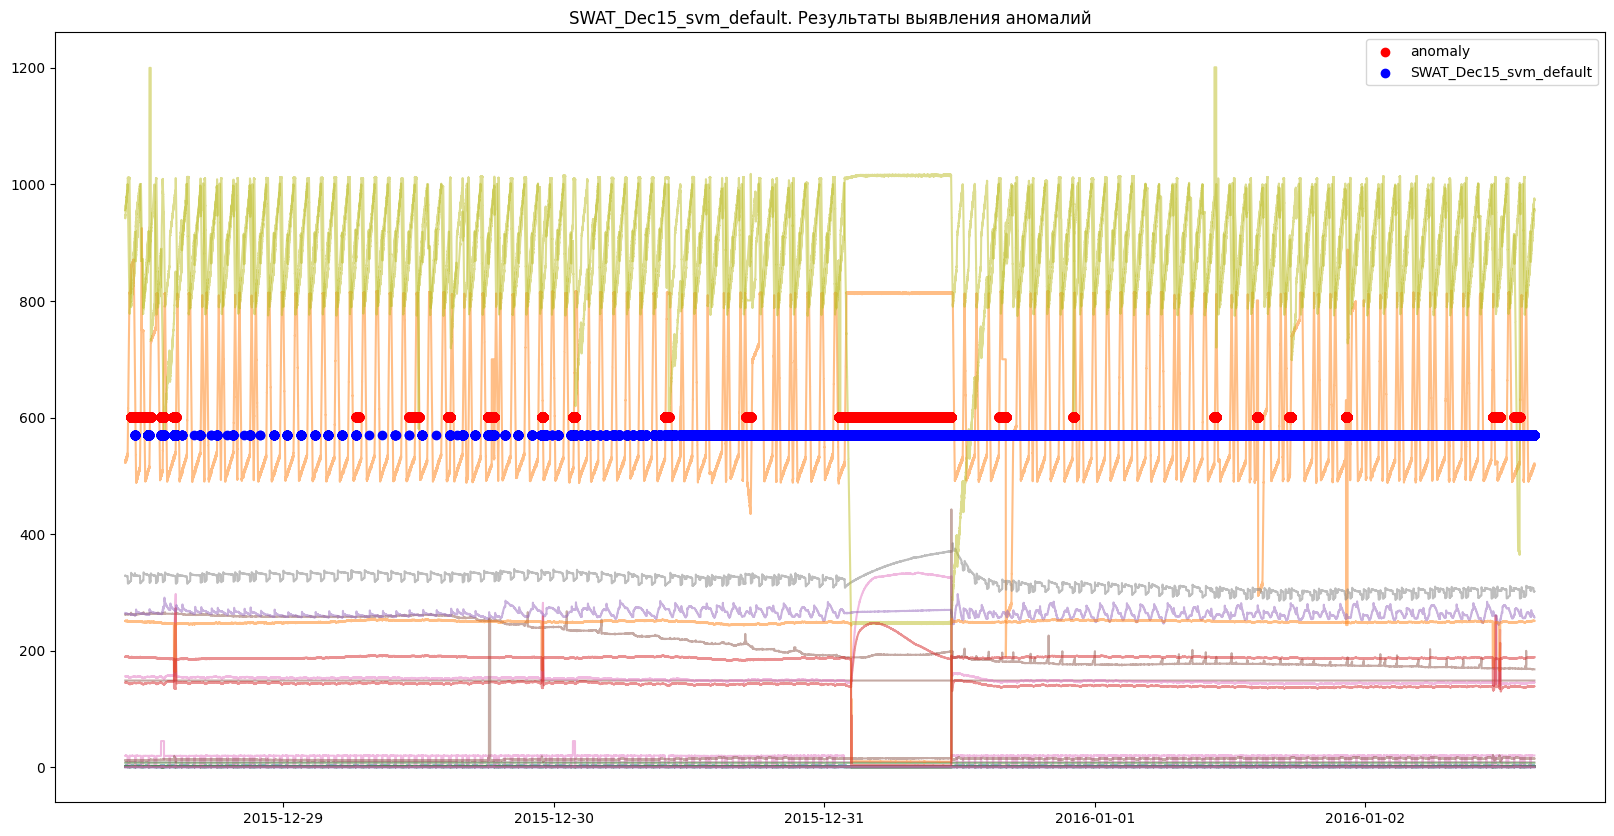

In [18]:
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (MinMax)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)
2022-09-05 19:34:45.079793: find saved model: ./saved_models/SWAT_Dec15_svm_minmax, loading...
SWAT_Dec15_svm_minmax
f1_score: 0.26
accuracy_score: 0.37
precision_score: 0.15
recall_score: 0.89


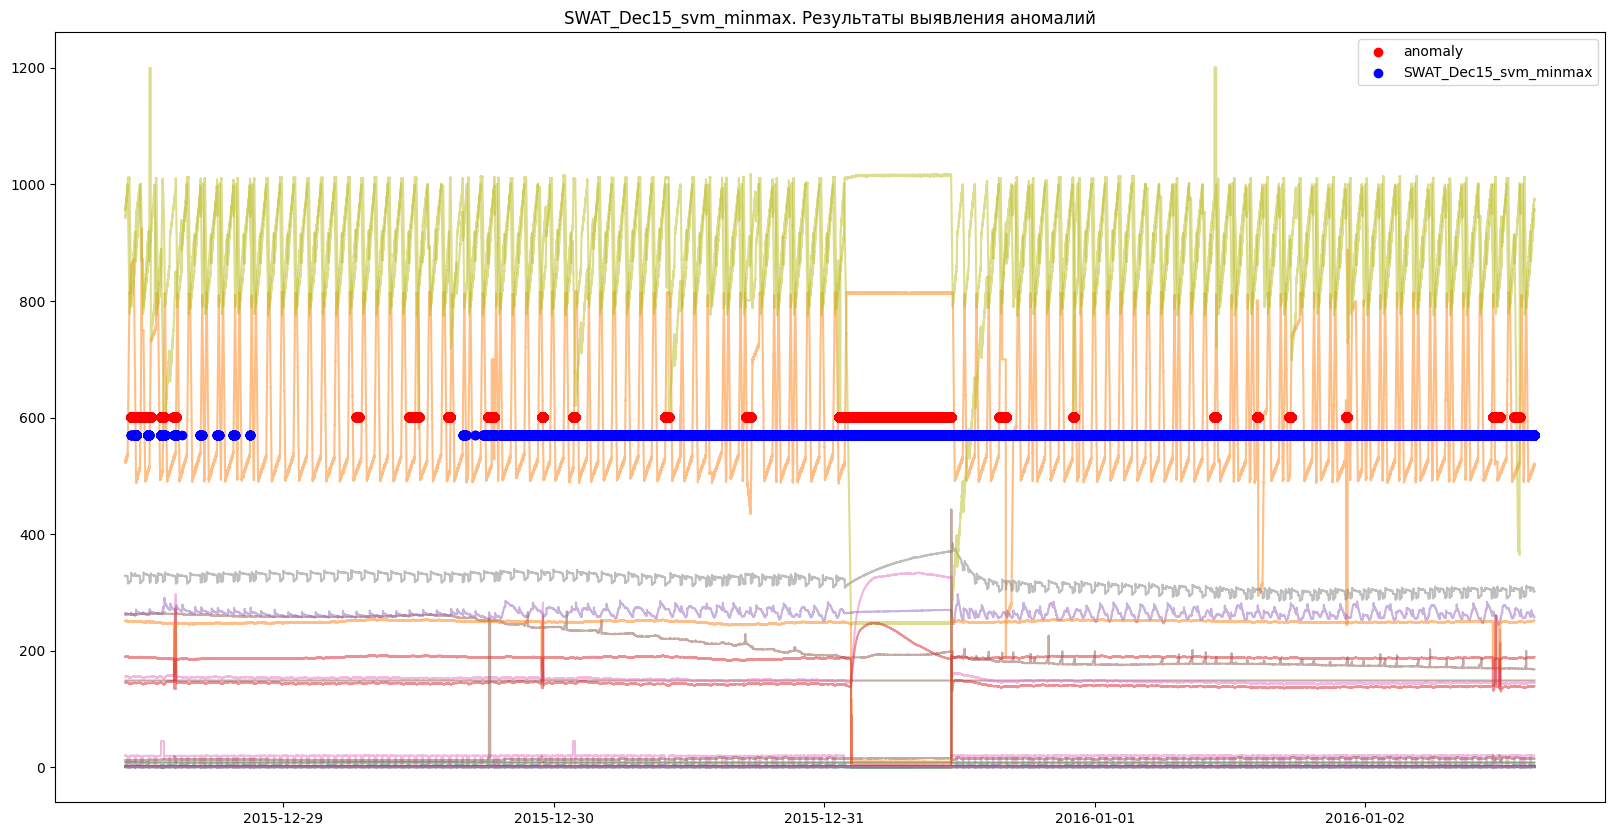

In [19]:
description='SWAT_Dec15_svm_minmax'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(),
                                        scaler='MinMax')

predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## LOF

In [20]:
anomaly_idx = [i for i in range(len(y_test)) if y_test[i] == 1]

In [21]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)


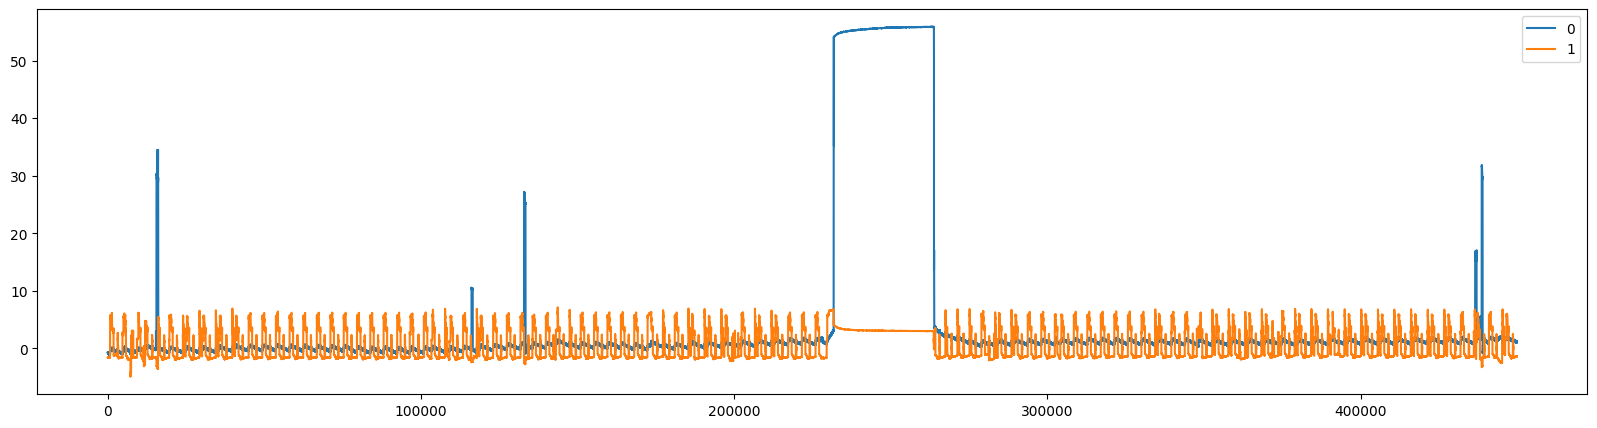

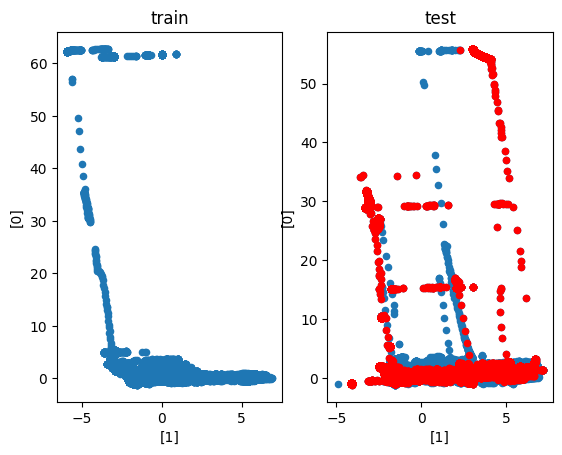

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit(x_train)

x_train_2d = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_2d = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_2d.plot(figsize=(20,5))

fig, (ax, ax_test) = plt.subplots(1, 2)
x_train_2d.plot.scatter(x=[1], y=[0], title='train', ax=ax)
x_test_2d.plot.scatter(x=[1], y=[0], title='test', ax=ax_test)
x_test_2d.iloc[anomaly_idx].plot.scatter(x=[1], y=[0], title='test', c='r', ax=ax_test)
plt.show()

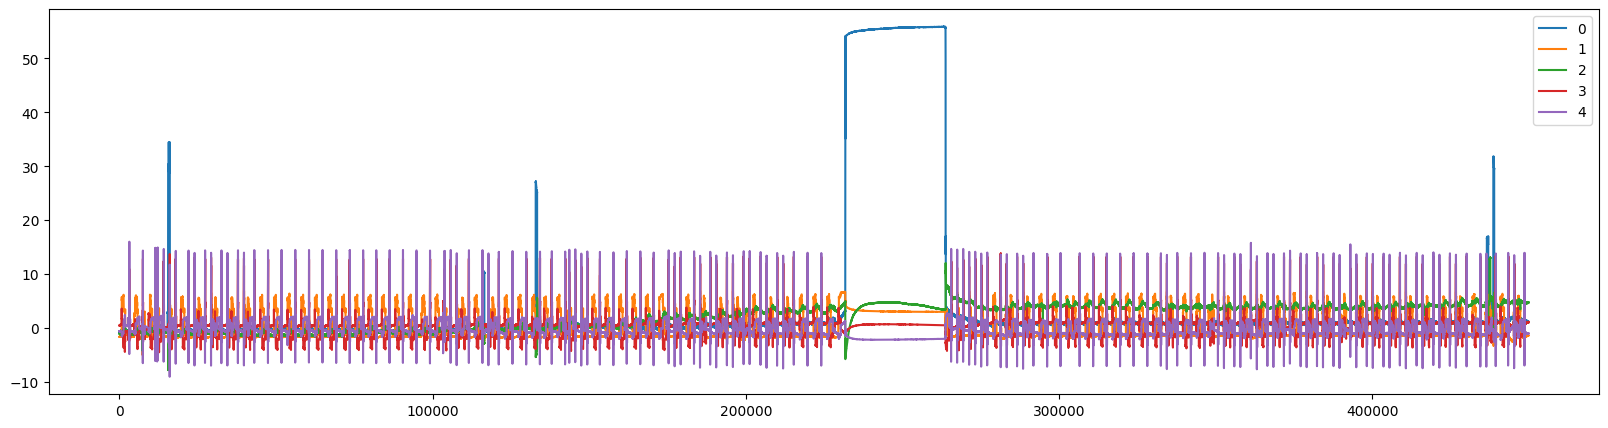

In [23]:
N_COMPONENTS = 5

pca = PCA(n_components=N_COMPONENTS)
principalComponents = pca.fit(x_train)

x_train_pca = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_pca = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_pca.plot(figsize=(20,5))
plt.show()

In [24]:
model = LOF()

2022-09-05 19:35:56.385909: find saved model: ./saved_models/SWAT_Dec15_lof_n5, loading...
Train prediction score statistics
            min: -165.84487051770736
            mean: -1.054604631220998
            max: -0.8895952013906652


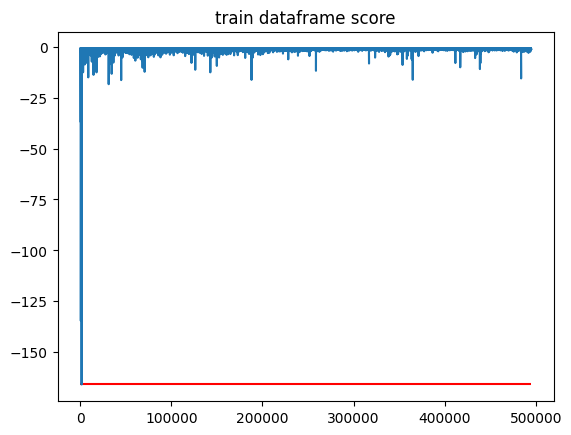

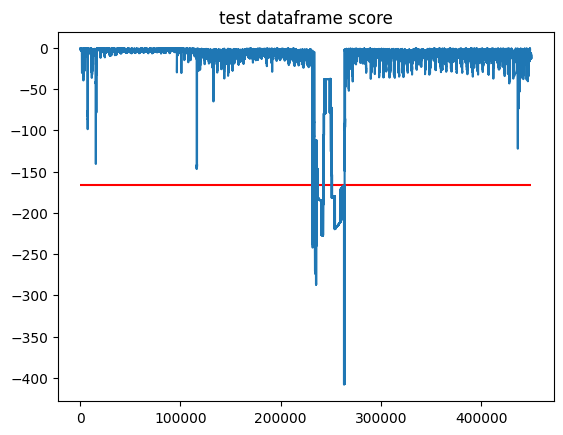

SWAT_Dec15_lof_n5
f1_score: 0.56
accuracy_score: 0.93
precision_score: 1.00
recall_score: 0.39


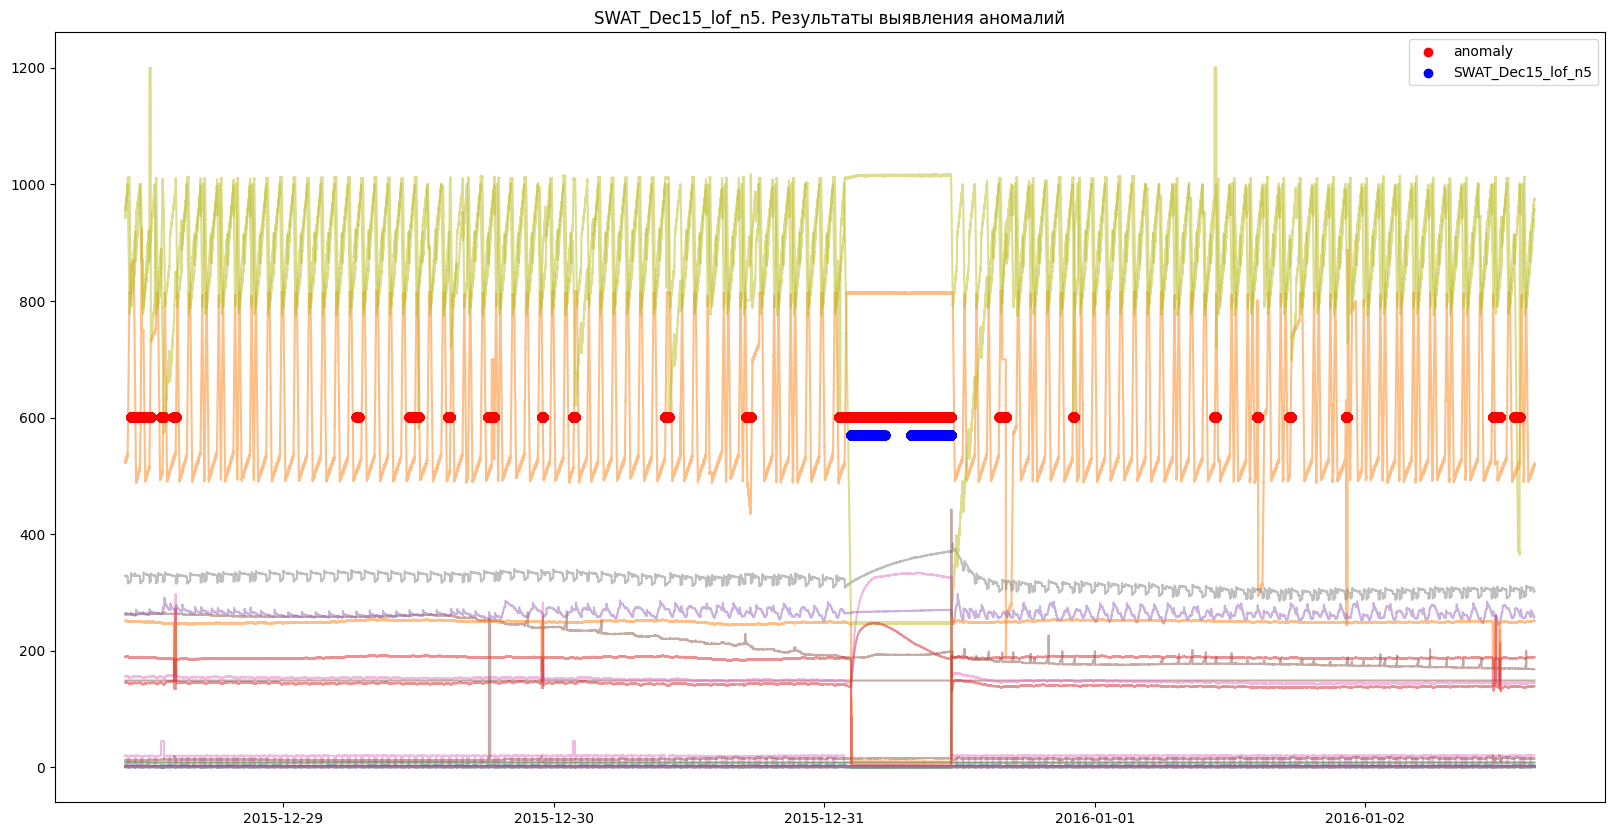

In [25]:
description = f'SWAT_Dec15_lof_n{N_COMPONENTS}'

predictor = Predictor(model, [x_train_pca, x_test_pca, y_test], 
                      descr=description, 
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

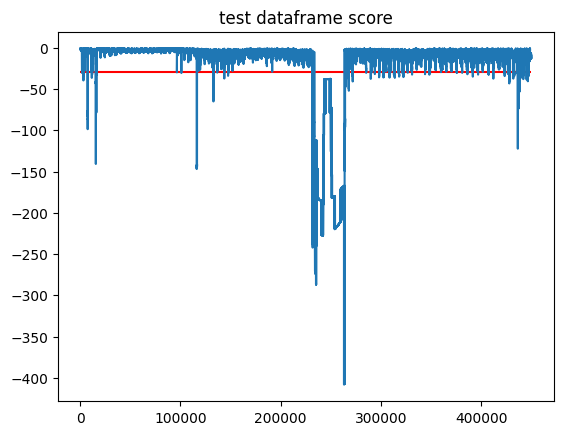

SWAT_Dec15_lof_n5
f1_score: 0.73
accuracy_score: 0.94
precision_score: 0.91
recall_score: 0.60


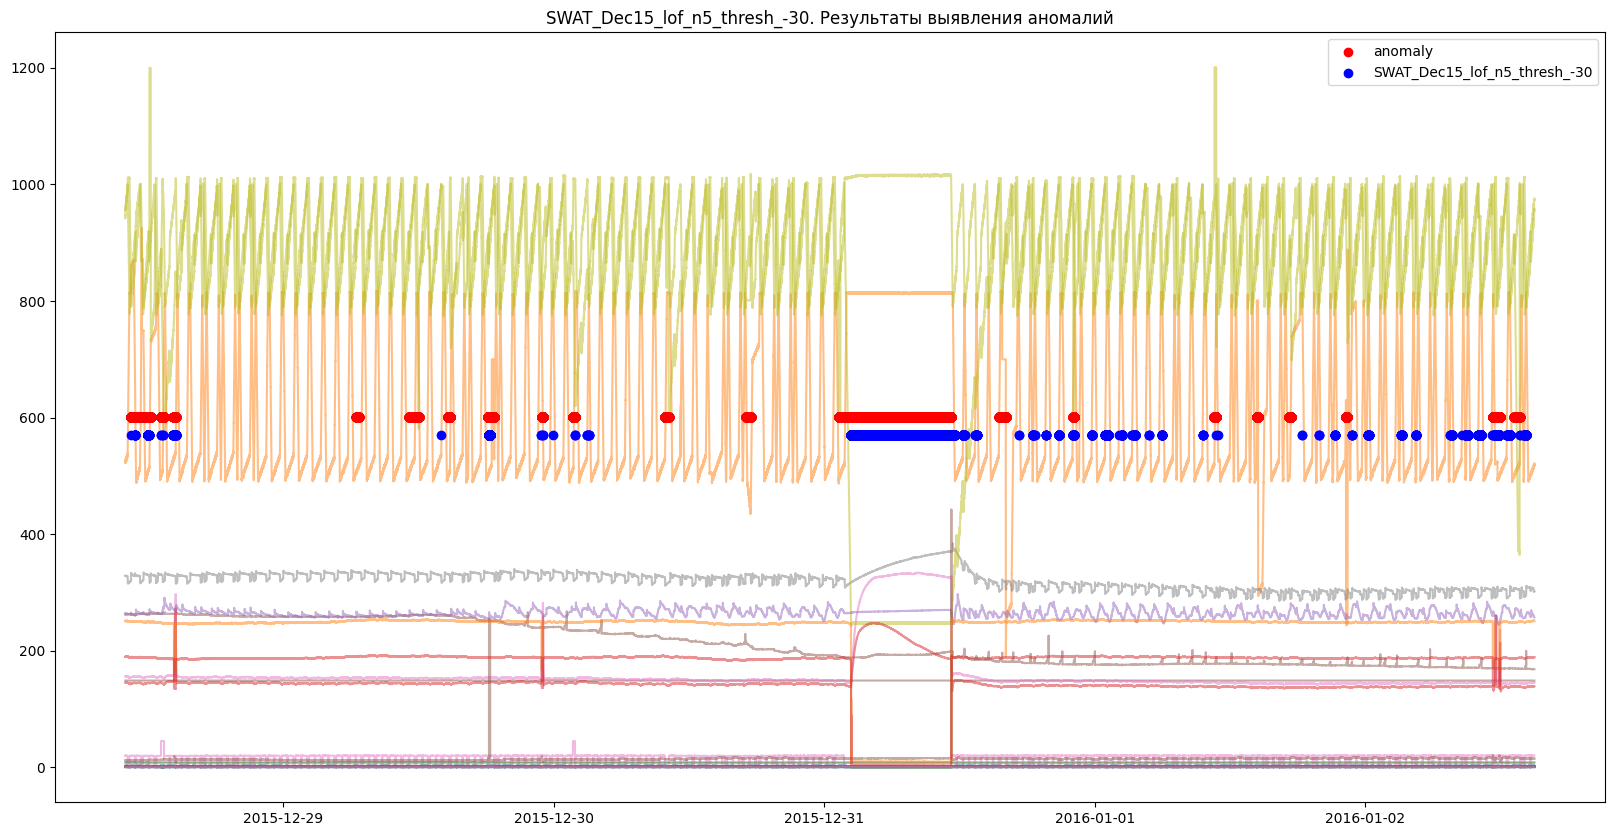

In [26]:
threshold = -30
description = f'SWAT_Dec15_lof_n{N_COMPONENTS}_thresh_{threshold}'

y_pred = predictor.get_anomalies(threshold = threshold)
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## iForest

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)
2022-09-05 19:36:31.209276: find saved model: ./saved_models/SWAT_Dec15_iF_default, loading...
SWAT_Dec15_iF_default
f1_score: 0.72
accuracy_score: 0.95
precision_score: 1.00
recall_score: 0.57


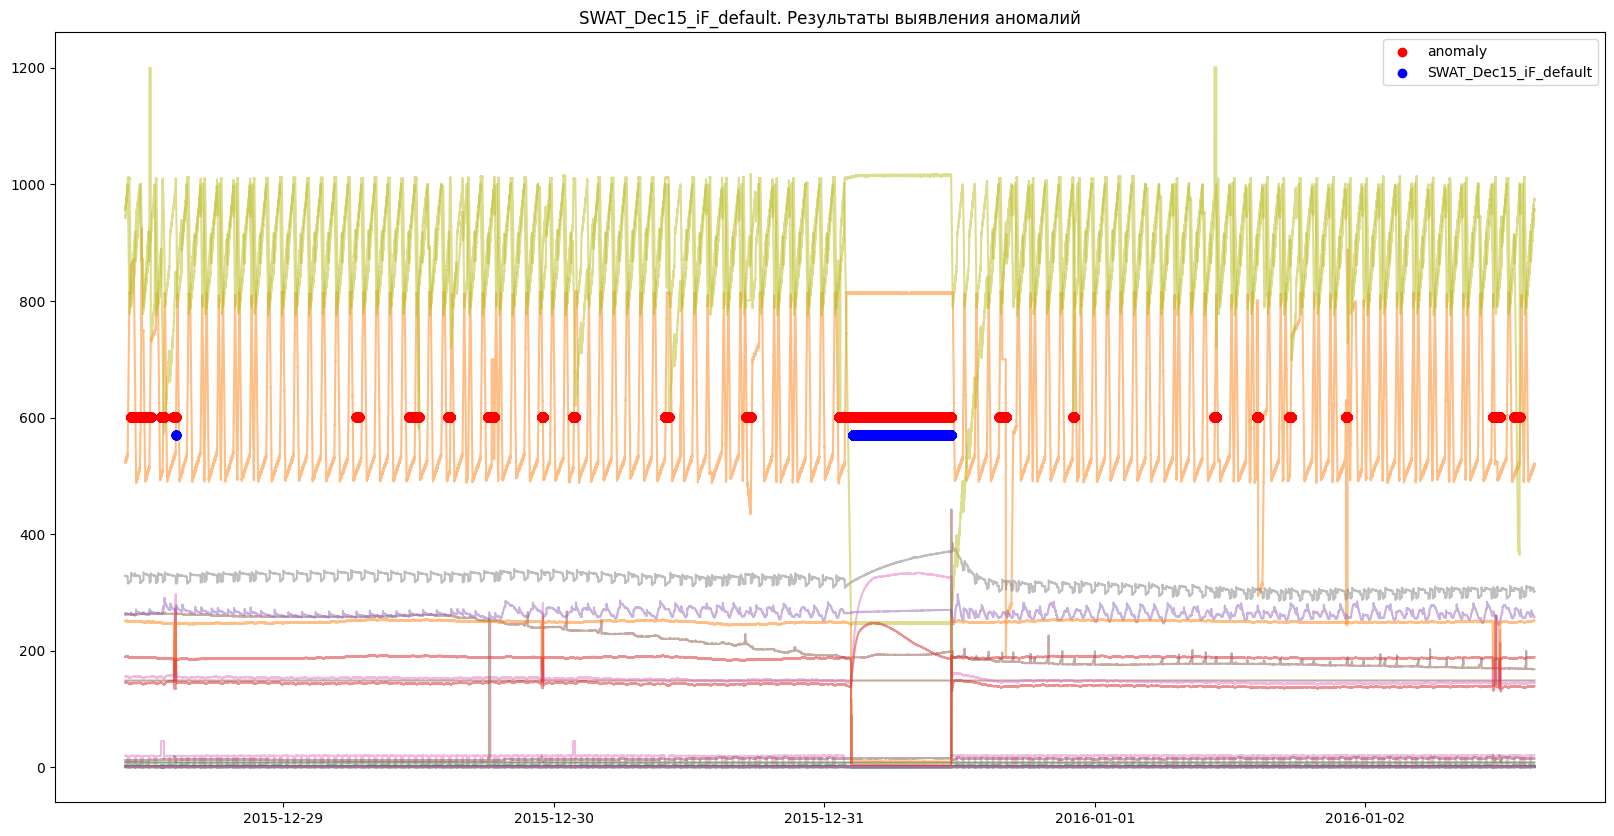

In [27]:
description = f'SWAT_Dec15_iF_default'

x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

model = iForest()

predictor = Predictor(model, [x_train, x_test, y_test], 
                      descr=description, 
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)
2022-09-05 19:36:43.790828: find saved model: ./saved_models/SWAT_Dec15_iF_n_200_c_0005, loading...
SWAT_Dec15_iF_n_200_c_0005
f1_score: 0.74
accuracy_score: 0.95
precision_score: 0.98
recall_score: 0.59


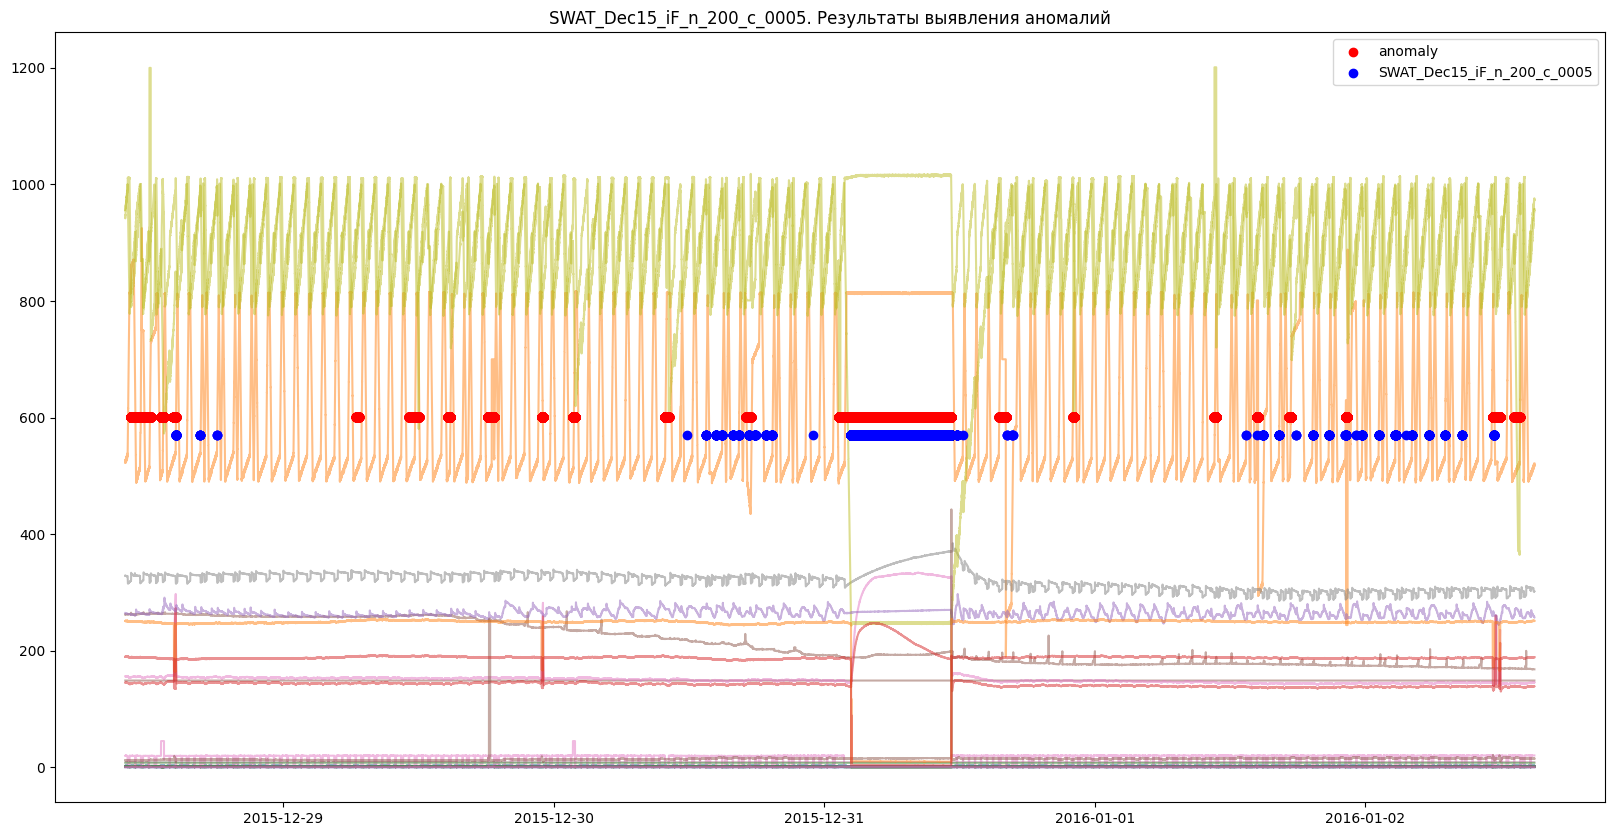

In [28]:
n_estimators, contamination = 200, 0.005

description = f"SWAT_Dec15_iF_n_{n_estimators}_c_{str(contamination).replace('.','')}"

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

model = iForest(n_estimators=n_estimators, contamination=contamination)

predictor = Predictor(model, [x_train, x_test, y_test], 
                      descr=description, 
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## Autoencoder

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Resampling... (1T)
(8250, 46), (7500, 46), (7500,),
Create sequences with window size 30...
Размеры выборок:
            x_train: (494971, 30, 46)
            x_test: (449890, 30, 46)
            y_test: (449890, 30)
2022-09-05 19:37:12.633489: refit model...


2022-09-05 19:37:12.597276: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-09-05 19:37:12.603223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 19:37:12.603649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.8GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-09-05 19:37:12.603697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 19:37:12.604104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:

Epoch 1/10
495/495 [==============================] - 79s 159ms/step - loss: 162.3058
Epoch 2/10
495/495 [==============================] - 79s 159ms/step - loss: 24.4282
Epoch 3/10
495/495 [==============================] - 79s 159ms/step - loss: 4.9976
Epoch 4/10
495/495 [==============================] - 79s 159ms/step - loss: 219.1779
Epoch 5/10
495/495 [==============================] - 79s 159ms/step - loss: 5.3906
Epoch 6/10
495/495 [==============================] - 79s 159ms/step - loss: 1.4432
Epoch 7/10
495/495 [==============================] - 79s 159ms/step - loss: 1.9694
Epoch 8/10
495/495 [==============================] - 79s 159ms/step - loss: 2.0148
Epoch 9/10
495/495 [==============================] - 79s 159ms/step - loss: 1.5284
Epoch 10/10
495/495 [==============================] - 79s 159ms/step - loss: 1.9824


2022-09-05 19:50:27.334740: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 2483392800 exceeds 10% of free system memory.
2022-09-05 19:51:46.528838: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 2483392800 exceeds 10% of free system memory.
2022-09-05 19:52:09.398655: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 2732239920 exceeds 10% of free system memory.


Train prediction score statistics
            min: 11.539351651886347
            mean: 21.63147330258595
            max: 5977.312132822594


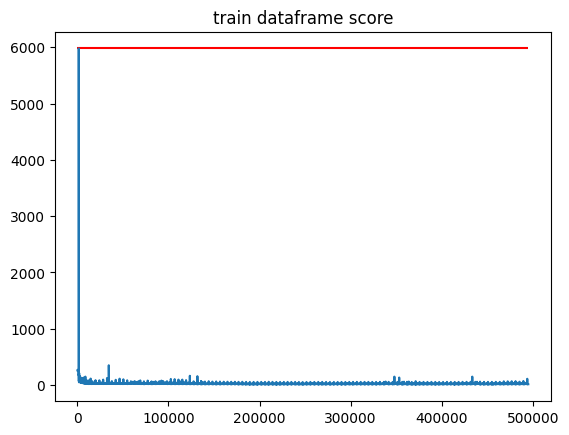

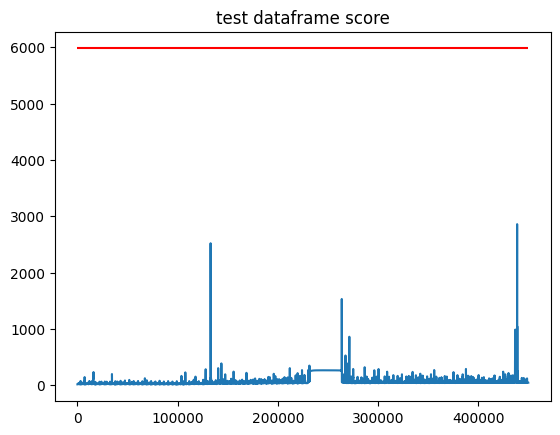

(449890,)
SWAT_Dec15_ae_lstm_window_30_resample_1T
f1_score: 0.00
accuracy_score: 0.88
precision_score: 0.00
recall_score: 0.00


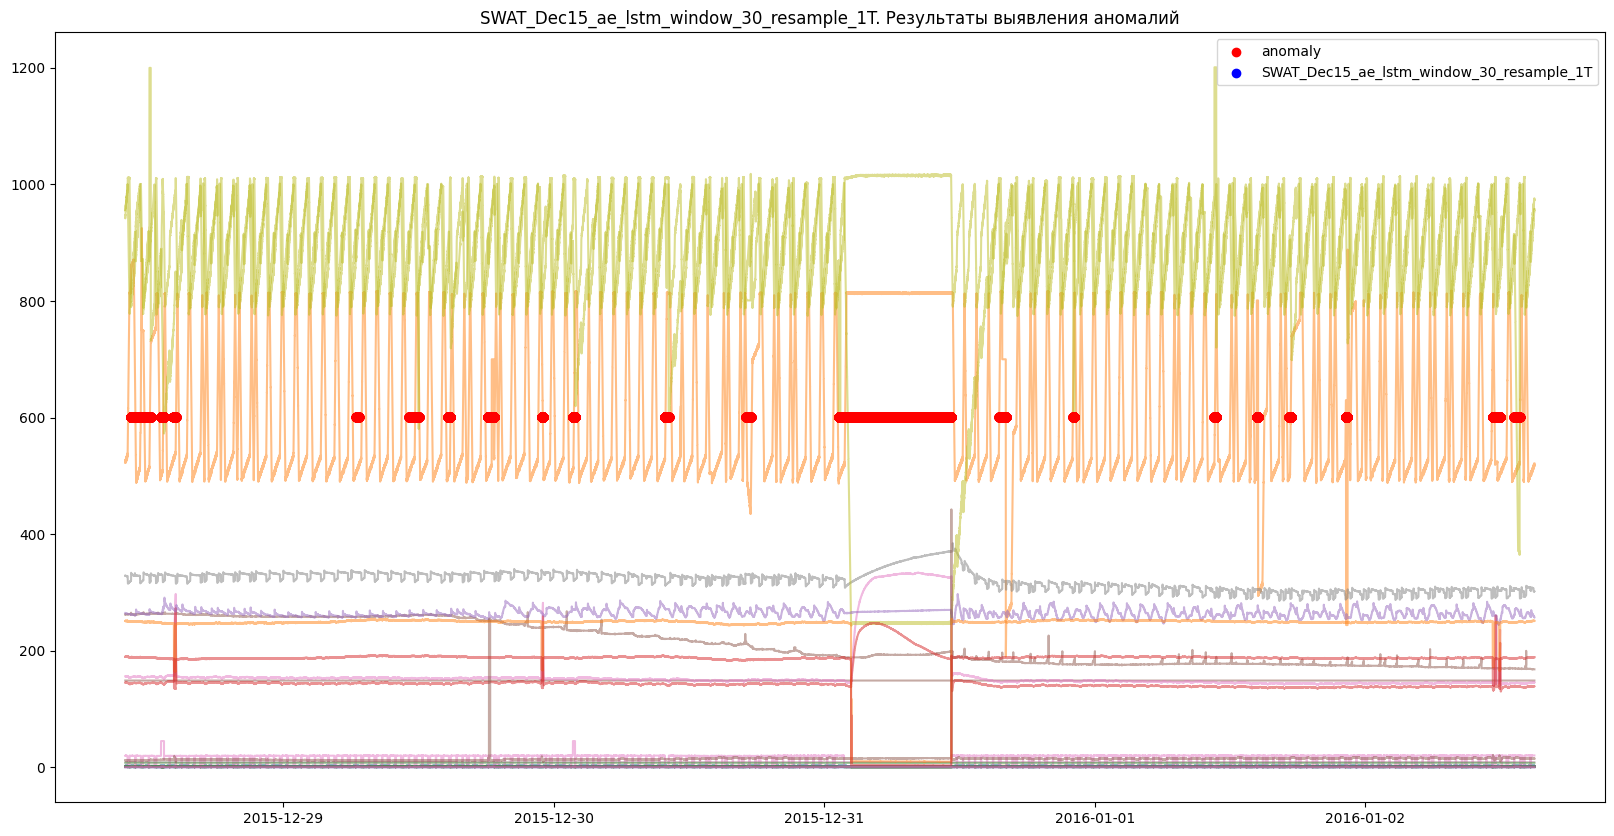

In [29]:
window_size = 30
resample_rate = '1T'

description = f'SWAT_Dec15_ae_lstm_window_{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

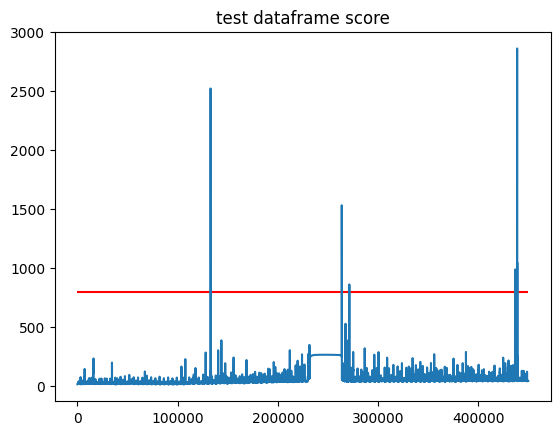

(449890,)
SWAT_Dec15_ae_lstm_window_30_resample_1T
f1_score: 0.00
accuracy_score: 0.88
precision_score: 0.60
recall_score: 0.00


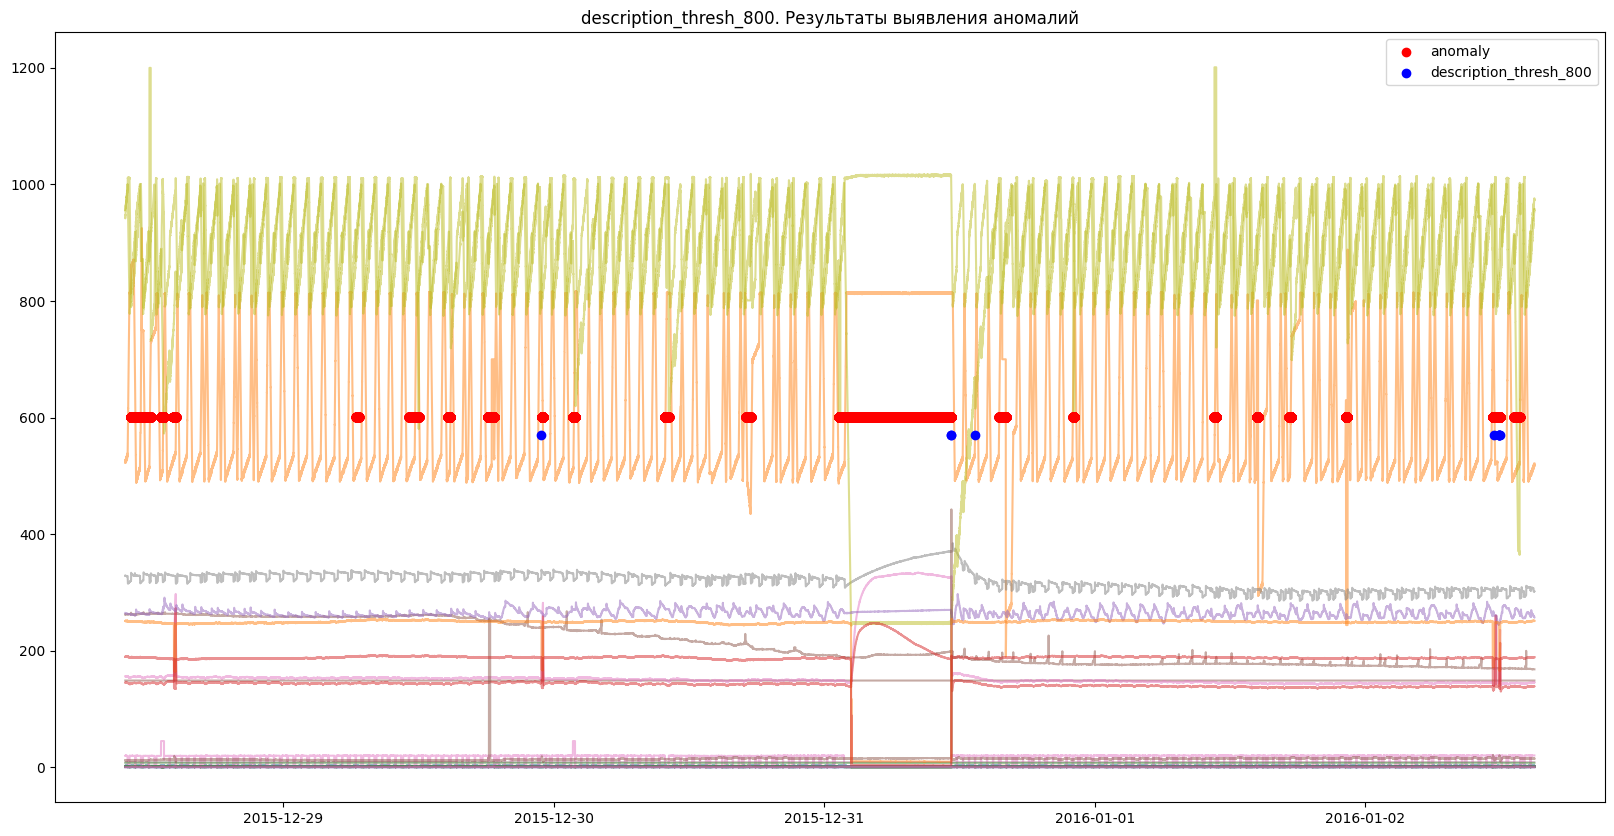

In [30]:
threshold = 800

y_pred = predictor.get_anomalies(threshold=threshold)
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=f'description_thresh_{threshold}')

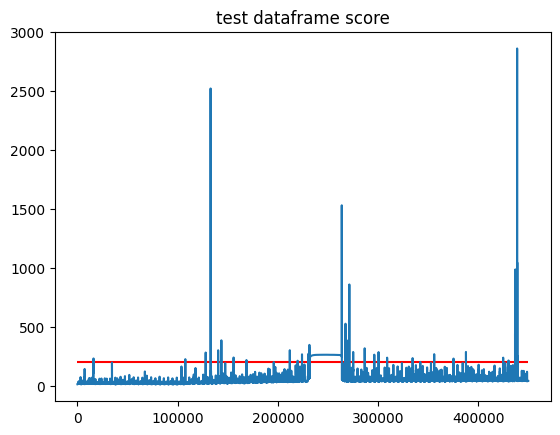

(449890,)
SWAT_Dec15_ae_lstm_window_30_resample_1T
f1_score: 0.74
accuracy_score: 0.95
precision_score: 1.00
recall_score: 0.59


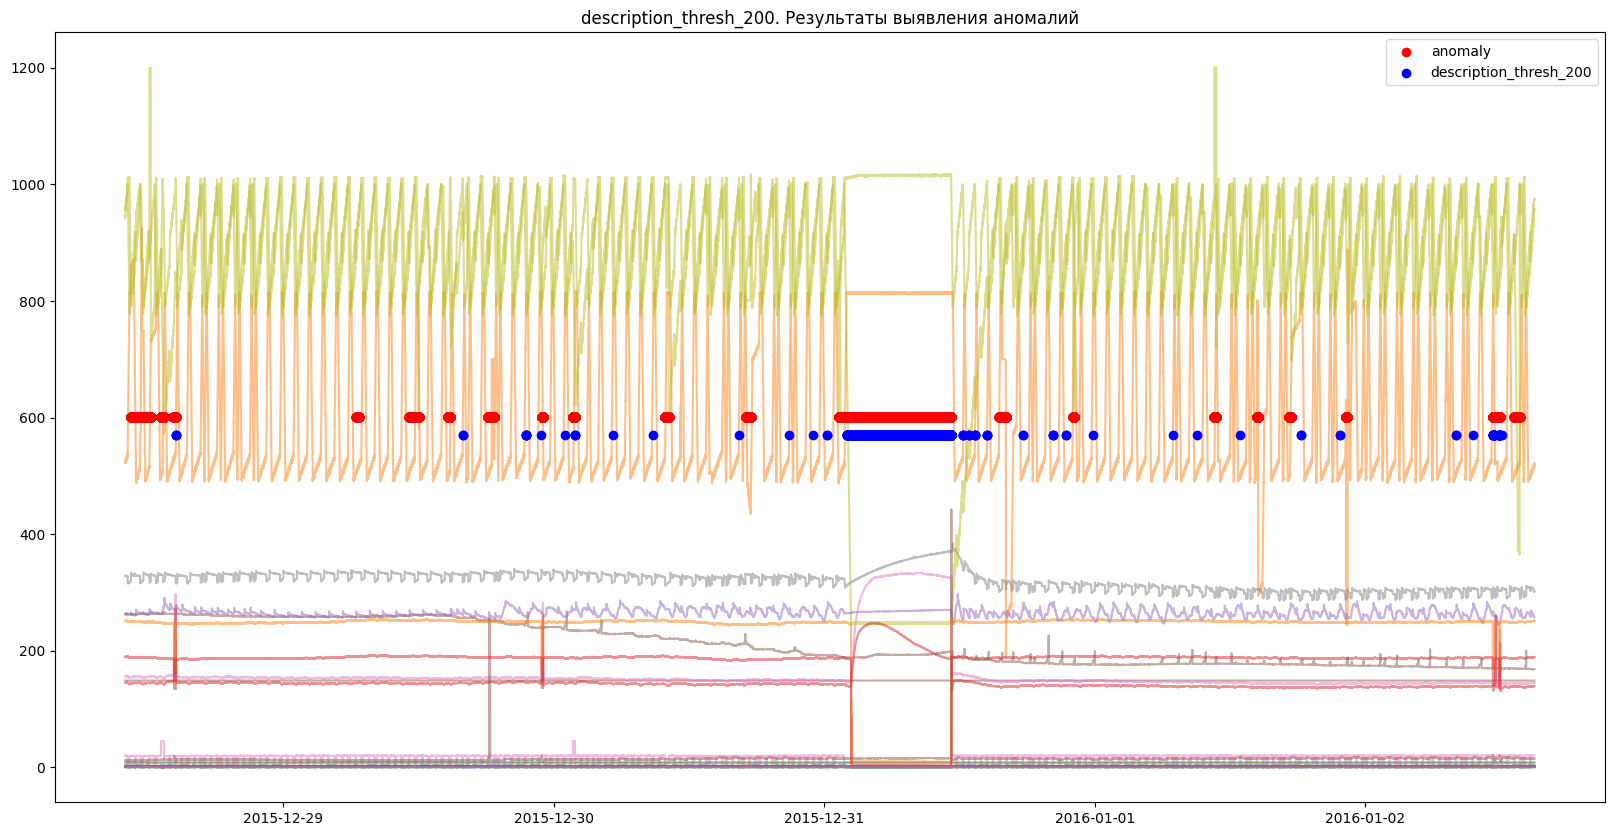

In [31]:
threshold = 200

y_pred = predictor.get_anomalies(threshold=threshold)
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=f'description_thresh_{threshold}')

## SOM

In [32]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)


2022-09-05 19:57:36.755015: find saved model: ./saved_models/SWAT_Dec15_som_default, loading...


IntProgress(value=0, description='Computing', max=449919, style=ProgressStyle(bar_color='#61dc8a'))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IntProgress(value=0, description='Computing', max=495000, style=ProgressStyle(bar_color='#61dc8a'))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Train prediction score statistics
            min: 0.7221285562490176
            mean: 53.020486145230784
            max: 784.0148065676423


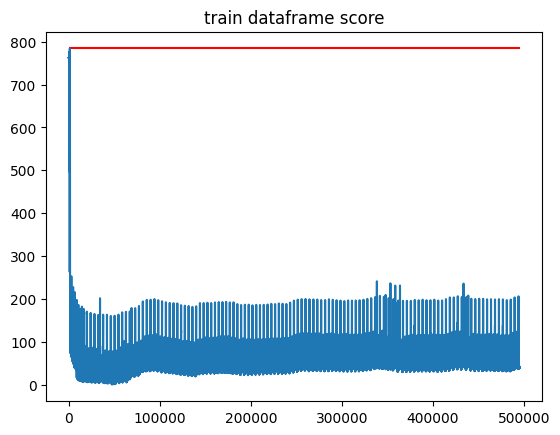

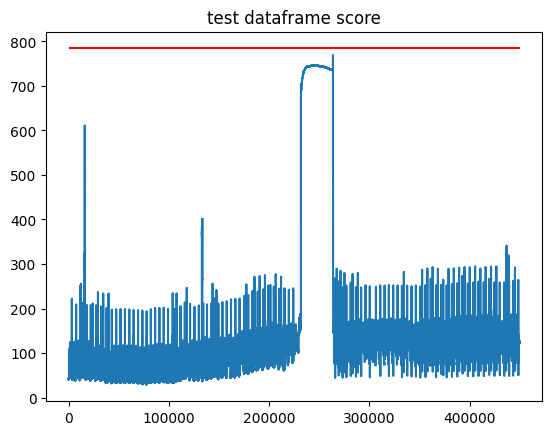

(449919,)
SWAT_Dec15_som_default
f1_score: 0.00
accuracy_score: 0.88
precision_score: 0.00
recall_score: 0.00


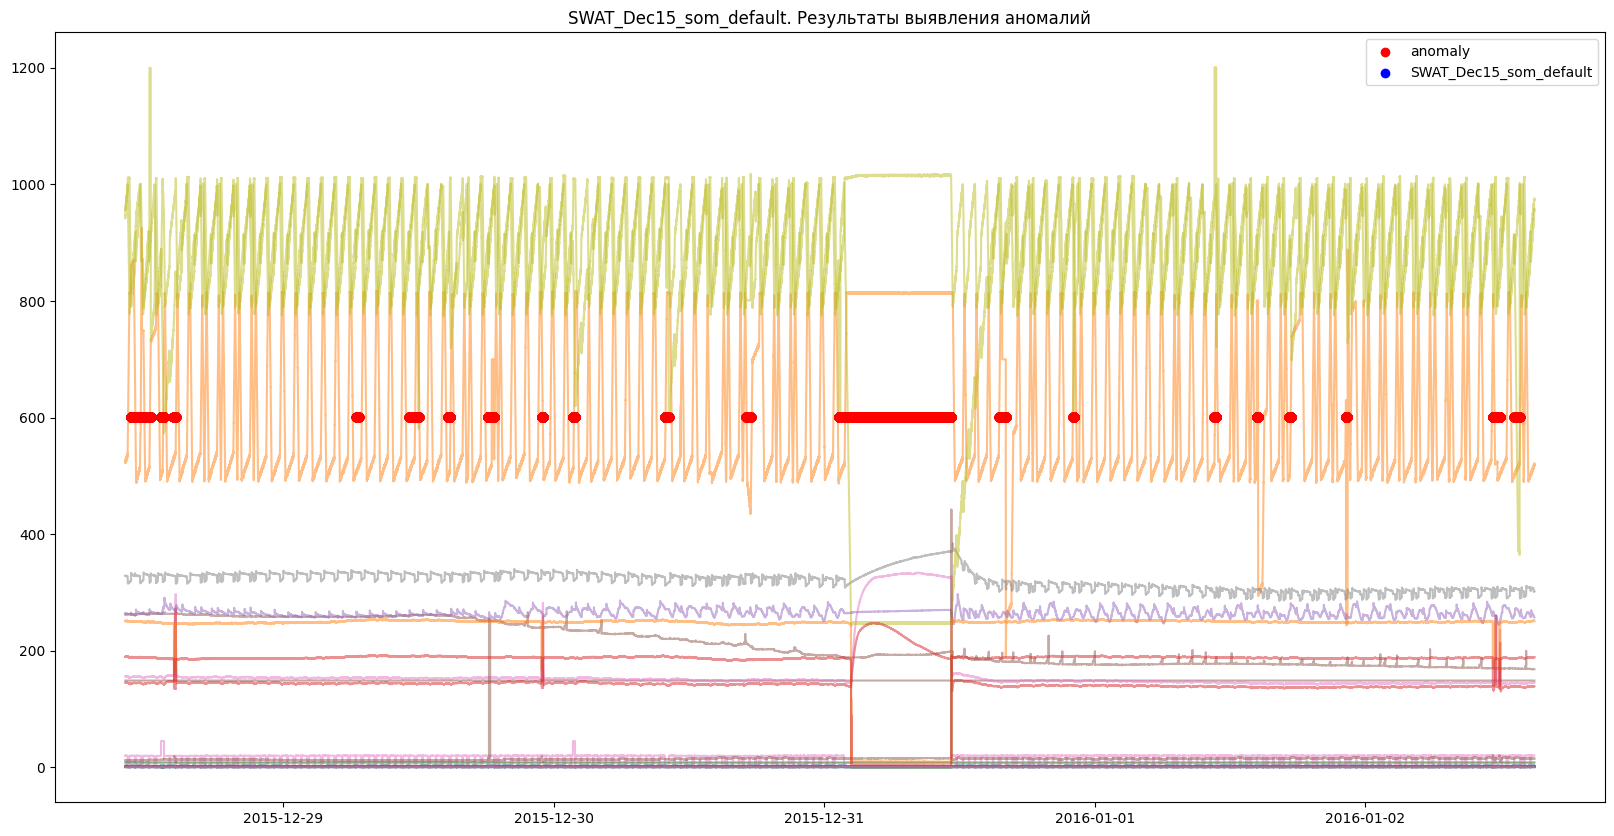

In [33]:
description = f'SWAT_Dec15_som_default'

model = SOM(x_train)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

IntProgress(value=0, description='Computing', max=449919, style=ProgressStyle(bar_color='#61dc8a'))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

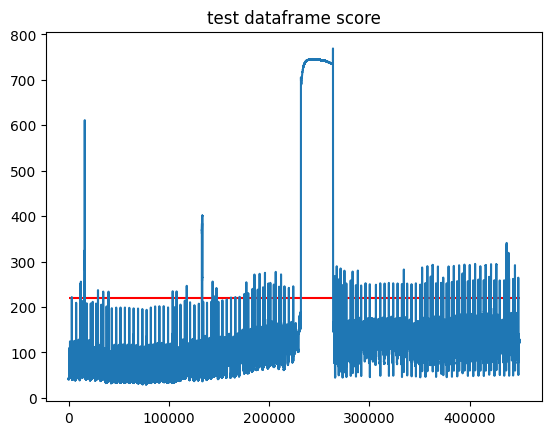

(449919,)
SWAT_Dec15_som_default
f1_score: 0.74
accuracy_score: 0.95
precision_score: 0.91
recall_score: 0.62


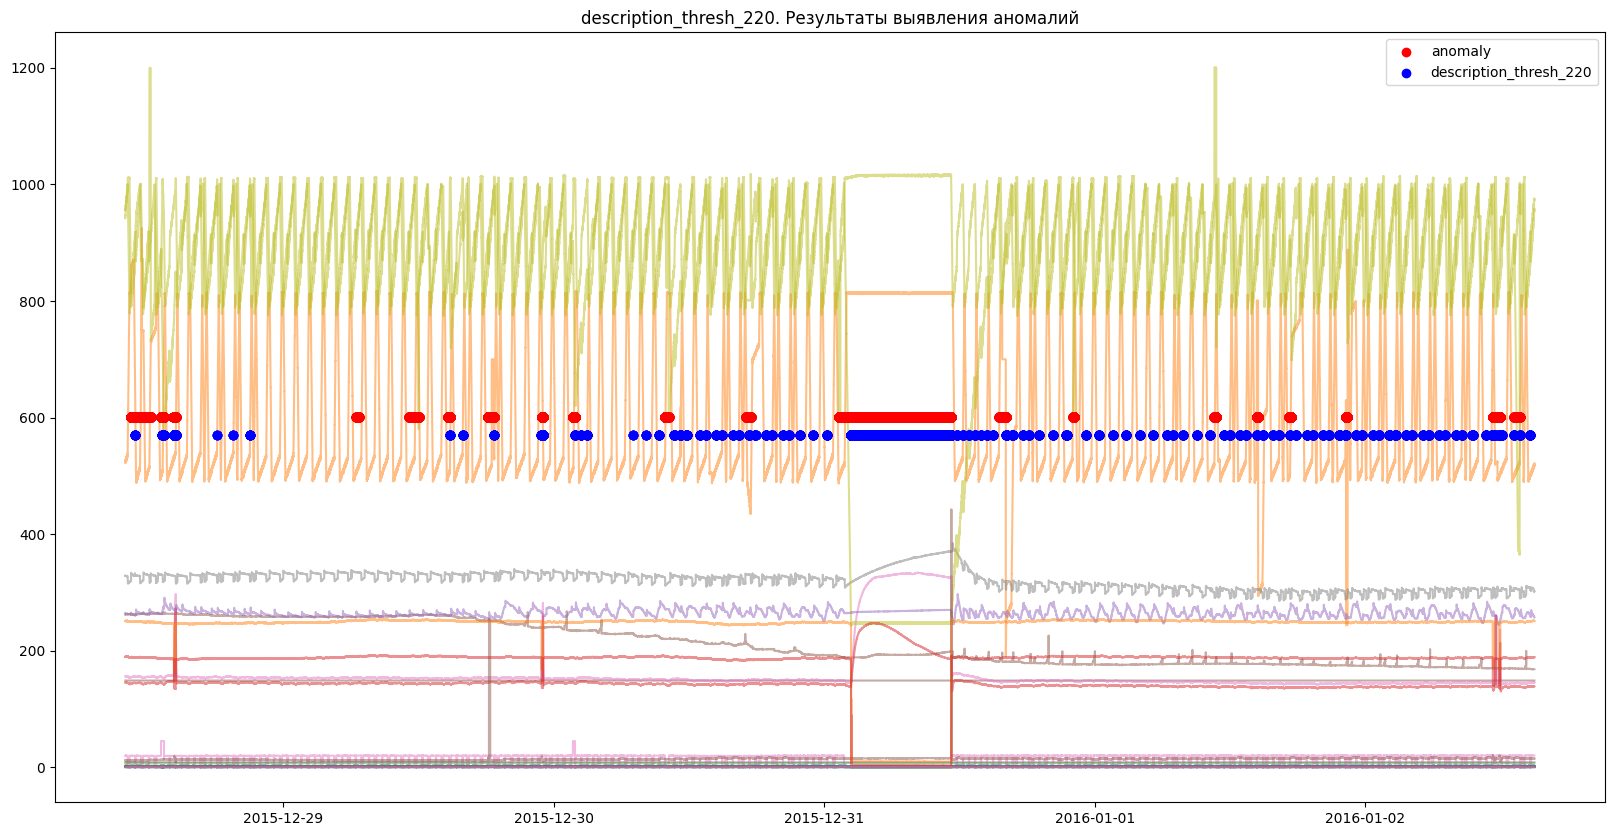

In [34]:
threshold = 220

y_pred = predictor.get_anomalies(threshold=threshold)
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=f'description_thresh_{threshold}')

## Auto Encoder (Deep Learning) in PyOD

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (496800, 46)
            x_test: (449919, 46)
            y_test: (449919,)
2022-09-08 12:53:40.541808: can't find saved model, fit model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 46)                2162      
                                                                 
 dropout_66 (Dropout)        (None, 46)                0         
                                                                 
 dense_73 (Dense)            (None, 46)                2162      
                                                                 
 dropout_67 (Dropout)        (None, 46)                0         
                                                                 
 dense_74 (Dense)            (None, 150000)            705

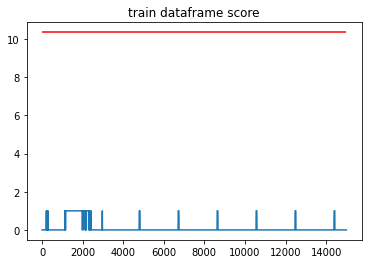

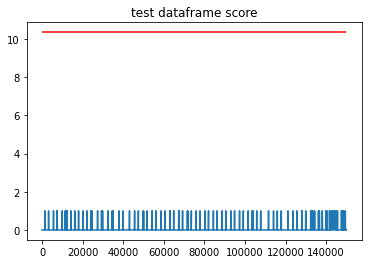

SWATjul9_AutoEnc
f1_score: 0.27
accuracy_score: 0.92
precision_score: 0.33
recall_score: 0.23


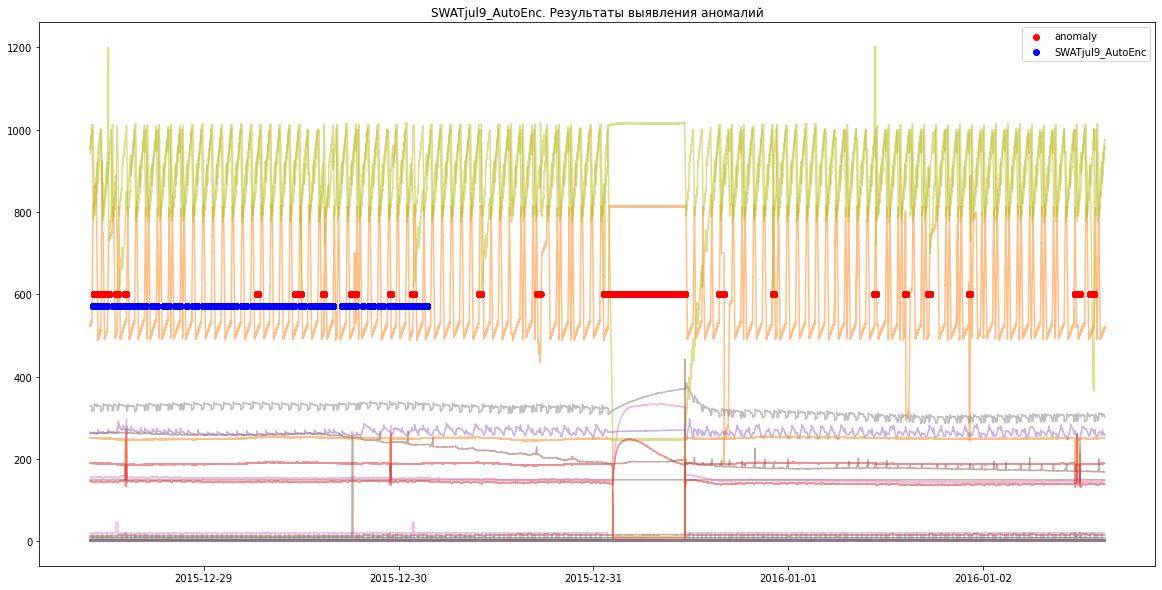

In [25]:
description = f'SWATjul9_AutoEnc'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

model = AutoEnc(x_train)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:], y_pred, descr=description)

# Сводная таблица

In [26]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

df_summary = pd.DataFrame(summary).T
df_summary.style.format("{0:,.2f}").background_gradient(cmap='Blues')